In [629]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [691]:
data_path = '/data/ajay/clip/nerf/nerf-pytorch/logs/061_blender_paper_lego_dump/consistency_data.pth'

## Load dumped data

In [692]:
with torch.no_grad():
    data = torch.load(data_path, map_location='cpu')

In [693]:
for k, v in data.items():
    try:
        print(k, v.shape)
    except:
        try:
            print(k, list(map(lambda x: x.shape, v)))
        except:
            print(k)

rays [torch.Size([168, 168, 3]), torch.Size([168, 168, 3])]
rgb torch.Size([168, 168, 3])
extras
rgbs torch.Size([2, 3, 224, 224])
target torch.Size([1, 3, 224, 224])
old_target torch.Size([1, 3, 400, 400])
rendered_pose torch.Size([3, 4])
target_pose torch.Size([3, 4])
stacked_embeddings torch.Size([3, 1, 256, 56, 56])
spatial_features torch.Size([3, 256, 56, 56])
HWF


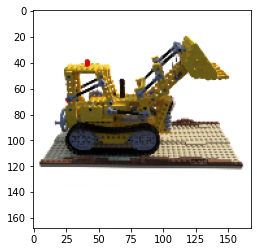

In [633]:
plt.imshow(data['rgb'].detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


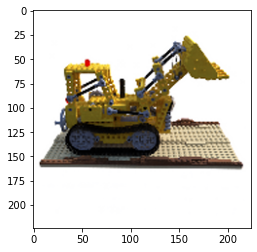

In [634]:
plt.imshow(data['rgbs'].detach()[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


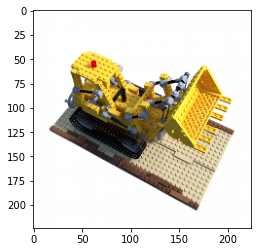

In [635]:
plt.imshow(data['target'].detach().squeeze(0).permute(1, 2, 0))

In [636]:
data['target'].shape

torch.Size([1, 3, 224, 224])

In [637]:
rgb_features, rgb0_features, target_features = data['spatial_features'].detach().float()

In [638]:
rgb_features.shape, rgb0_features.shape, target_features.shape

(torch.Size([256, 56, 56]),
 torch.Size([256, 56, 56]),
 torch.Size([256, 56, 56]))

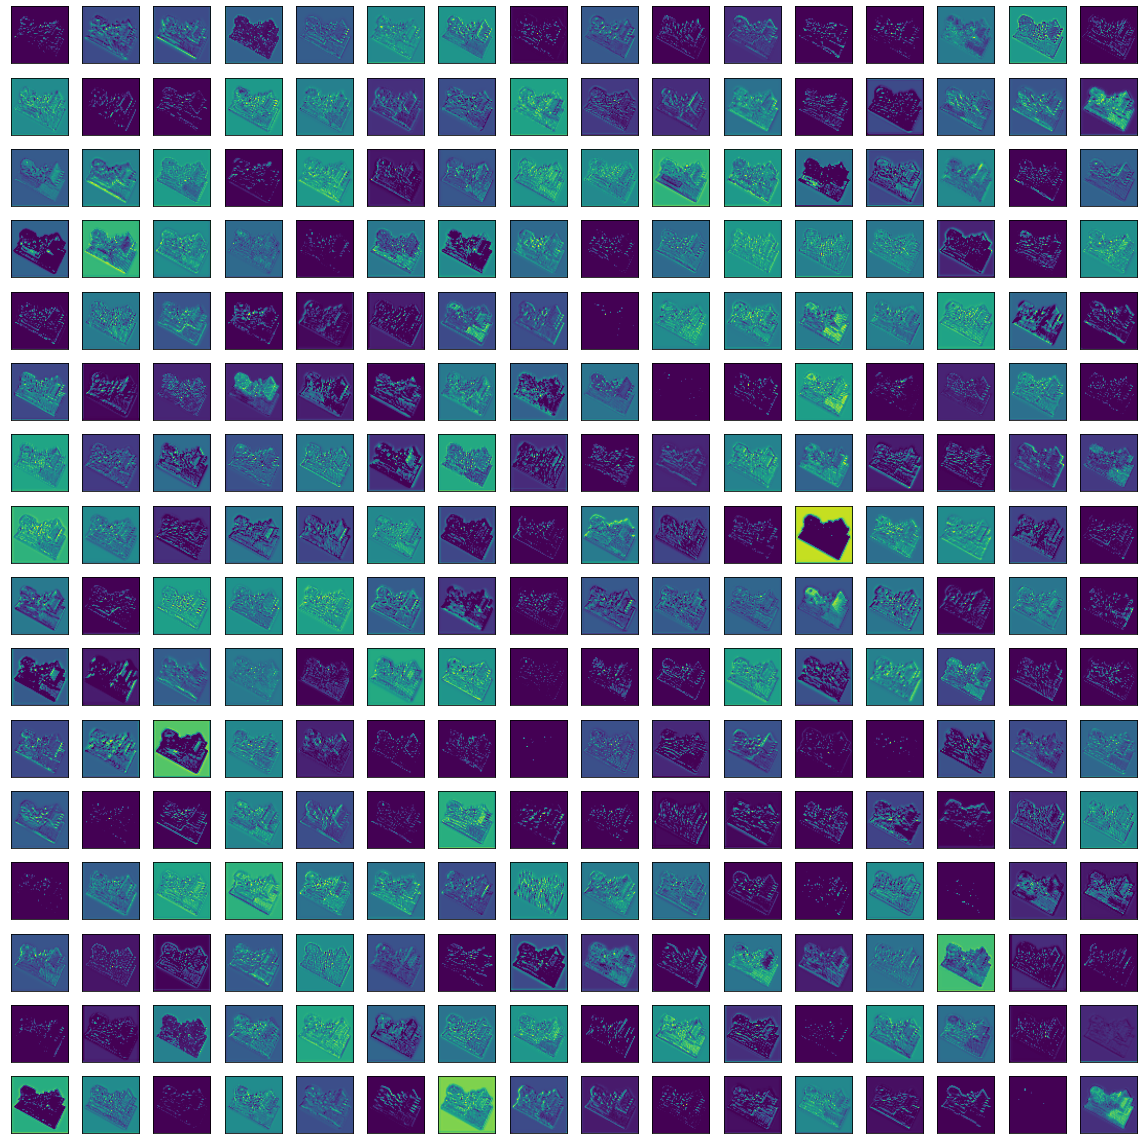

In [11]:
fig, axes = plt.subplots(16, 16, figsize=(16, 16))
for r in range(16):
    for c in range(16):
        axes[r, c].imshow(target_features[r * 16 + c][:, :, None])
        axes[r, c].axes.xaxis.set_visible(False)
        axes[r, c].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.show()

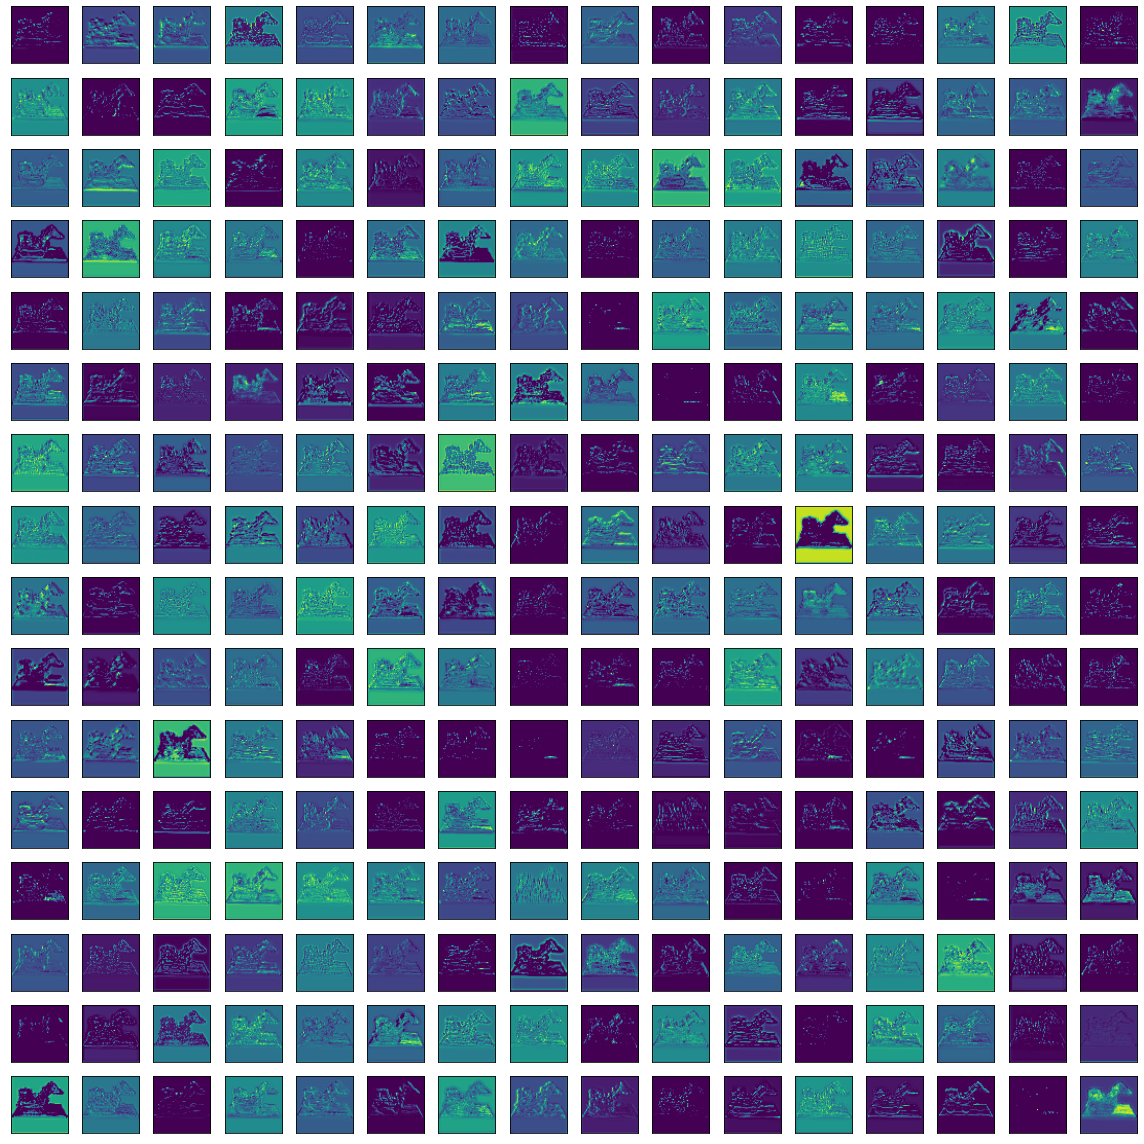

In [251]:
fig, axes = plt.subplots(16, 16, figsize=(16, 16))
for r in range(16):
    for c in range(16):
        axes[r, c].imshow(rgb_features[r * 16 + c][:, :, None])
        axes[r, c].axes.xaxis.set_visible(False)
        axes[r, c].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.show()

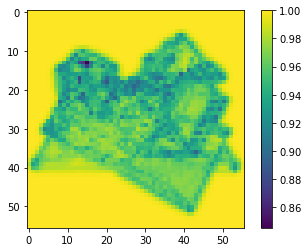

In [252]:
with torch.no_grad():
    unaligned_sim = torch.nn.functional.cosine_similarity(rgb_features, target_features, dim=0)

plt.imshow(unaligned_sim)
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


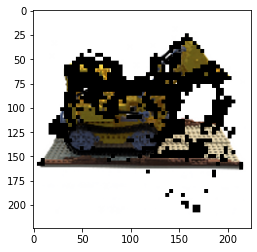

In [253]:
with torch.no_grad():
    unaligned_sim_big = torch.nn.functional.interpolate(unaligned_sim.unsqueeze(0).unsqueeze(0), size=(224, 224))
    print(data['rgbs'][0].shape)
    rgb_masked = data['rgbs'][0] * (unaligned_sim_big.squeeze(0) > 0.95)
    plt.imshow(rgb_masked.permute(1, 2, 0))

## Project rays

In [254]:
rays_o, rays_d = data['rays']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


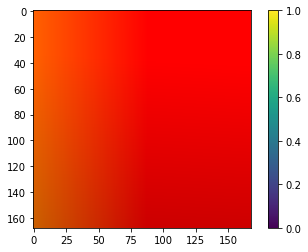

In [255]:
# plt.imshow((rays_d - rays_d.min()) / rays_d.max())
# plt.imshow((rays_d + rays_d.min(), vmax=rays_d.max())
plt.imshow(rays_d)
plt.colorbar()

In [256]:
rays_d

tensor([[[ 1.0549,  0.3812, -0.0315],
         [ 1.0550,  0.3769, -0.0315],
         [ 1.0551,  0.3726, -0.0315],
         ...,
         [ 1.0691, -0.3283, -0.0315],
         [ 1.0692, -0.3326, -0.0315],
         [ 1.0693, -0.3369, -0.0315]],

        [[ 1.0534,  0.3811, -0.0355],
         [ 1.0535,  0.3768, -0.0355],
         [ 1.0535,  0.3725, -0.0355],
         ...,
         [ 1.0676, -0.3283, -0.0355],
         [ 1.0677, -0.3326, -0.0355],
         [ 1.0677, -0.3369, -0.0355]],

        [[ 1.0518,  0.3811, -0.0395],
         [ 1.0519,  0.3768, -0.0395],
         [ 1.0520,  0.3725, -0.0395],
         ...,
         [ 1.0660, -0.3283, -0.0395],
         [ 1.0661, -0.3326, -0.0395],
         [ 1.0662, -0.3369, -0.0395]],

        ...,

        [[ 0.7950,  0.3760, -0.6917],
         [ 0.7951,  0.3717, -0.6917],
         [ 0.7952,  0.3674, -0.6917],
         ...,
         [ 0.8092, -0.3335, -0.6917],
         [ 0.8093, -0.3378, -0.6917],
         [ 0.8094, -0.3421, -0.6917]],

        [[

In [257]:
w2c_rotation = data['rendered_pose'][:, :3].T

In [258]:
data['extras'].keys()

dict_keys(['pts', 'raw', 'rgb0'])

In [259]:
data['extras']['pts'].shape

torch.Size([168, 168, 192, 3])

**Sample points along rays**

In [260]:
import sys
sys.path.append('/data/ajay/clip/nerf/nerf-pytorch/')
from run_nerf_helpers import ndc_rays

In [261]:
# # use provided ray batch
# rays_o, rays_d = data['rays']
# H,W,focal = data['HWF']
# use_viewdirs = True
# c2w_staticcam = None
# ndc = True
# near = 0.
# far = 1.

# print(rays_o.shape, rays_d.shape)

# if use_viewdirs:
#     # provide ray directions as input
#     viewdirs = rays_d
#     if c2w_staticcam is not None:
#         # special case to visualize effect of viewdirs
#         rays_o, rays_d = get_rays(H, W, focal, c2w_staticcam)
#     viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
#     viewdirs = torch.reshape(viewdirs, [-1,3]).float()

# print(rays_o.shape, rays_d.shape, rays_o)
    
# sh = rays_d.shape # [..., 3]
# if ndc:
#     # for forward facing scenes
#     print('ndc')
#     rays_o, rays_d = ndc_rays(H, W, focal, 1., rays_o, rays_d)

# print(rays_o.shape, rays_d.shape, rays_o)
    
# # Create ray batch
# rays_o = torch.reshape(rays_o, [-1,3]).float()
# rays_d = torch.reshape(rays_d, [-1,3]).float()

# print(rays_o.shape, rays_d.shape)

# near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])

# print(near.shape, far.shape)

# rays = torch.cat([rays_o, rays_d, near, far], -1)
# if use_viewdirs:
#     rays = torch.cat([rays, viewdirs], -1)

# print(viewdirs.shape)
# print(rays.shape)

**Access raw sample data**

In [262]:
data['extras']['raw'].shape

torch.Size([168, 168, 192, 4])

In [263]:
data['extras']['pts'].shape

torch.Size([168, 168, 192, 3])

In [616]:
data.keys()

dict_keys(['rays', 'rgb', 'extras', 'rgbs', 'target', 'old_target', 'rendered_pose', 'target_pose', 'stacked_embeddings', 'spatial_features', 'HWF'])

In [617]:
H, W, focal = data['HWF']
samples_per_ray = data['extras']['pts'].shape[2]
cH, cW = 168, 168
pixel_interpolation_mode = 'bicubic'
feature_interpolation_mode = 'bilinear'

# Create world to target camera transformation
c2w_rotation = data['target_pose'][:, :3]
camera_origin = data['target_pose'][:, 3].unsqueeze(1)
w2c = torch.cat([c2w_rotation.T, -c2w_rotation.T.mm(camera_origin)], dim=1)

# Transform rendered rays
rendered_pts_extended = torch.cat([rendered_pts, torch.ones_like(rendered_pts[..., 0:1])], dim=-1)
rendered_pts_camera = torch.einsum('cw,absw->absc', w2c, rendered_pts_extended)

# Convert to image coordinates
uv = -rendered_pts_camera[..., :2] / rendered_pts_camera[..., 2:]  # [H,W,B,2]
uv = uv * data['HWF'][2] + torch.tensor([[data['HWF'][0]/2., data['HWF'][1]/2.]])
uv[..., 1] = data['HWF'][0] - uv[..., 1]

# Resize target image and features
with torch.no_grad():
    target_resize = torch.nn.functional.interpolate(data['target'], (H, W), mode=pixel_interpolation_mode)
    target_features_resize = torch.nn.functional.interpolate(target_features.unsqueeze(0), (H, W), mode=feature_interpolation_mode)
    target_features_resize_c = torch.nn.functional.interpolate(target_features.unsqueeze(0), (cH, cW), mode=feature_interpolation_mode)

# Resize rendered image and features
rgb_resize = torch.nn.functional.interpolate(data['rgb'].permute(2, 0, 1).unsqueeze(0), (H, W), mode=pixel_interpolation_mode)
rgb_features_resize = torch.nn.functional.interpolate(rgb_features.unsqueeze(0), (H, W), mode=feature_interpolation_mode)
rgb_features_resize_c = torch.nn.functional.interpolate(rgb_features.unsqueeze(0), (cH, cW), mode=feature_interpolation_mode)    
    
print(target_resize.shape, target_features_resize_c.shape, target_features_resize.shape)

torch.Size([1, 3, 400, 400]) torch.Size([1, 256, 168, 168]) torch.Size([1, 256, 400, 400])


/home/ajay/miniconda3/envs/clip/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/home/ajay/miniconda3/envs/clip/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


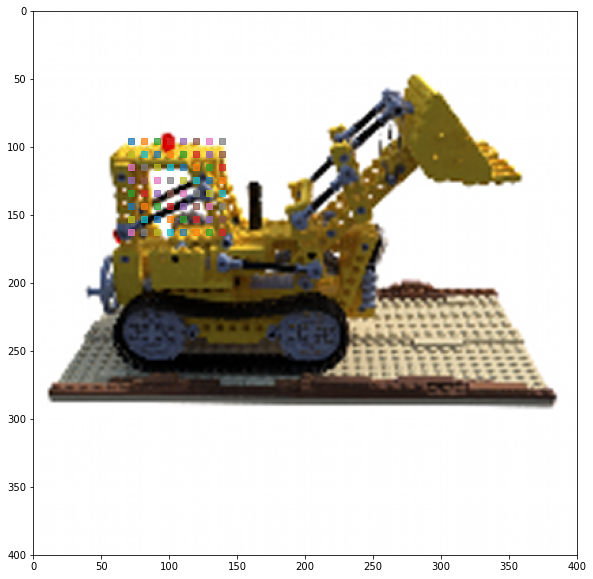

In [597]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb_resize.detach()[0].permute(1,2,0))
plt.plot(uv[40:70:4, 30:60:4, -1, 0].reshape(-1, 1).T,
         uv[40:70:4, 30:60:4, -1, 1].reshape(-1, 1).T, alpha=0.75, linewidth=4, marker='s')
plt.ylim([H, 0])
plt.xlim([0, W])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


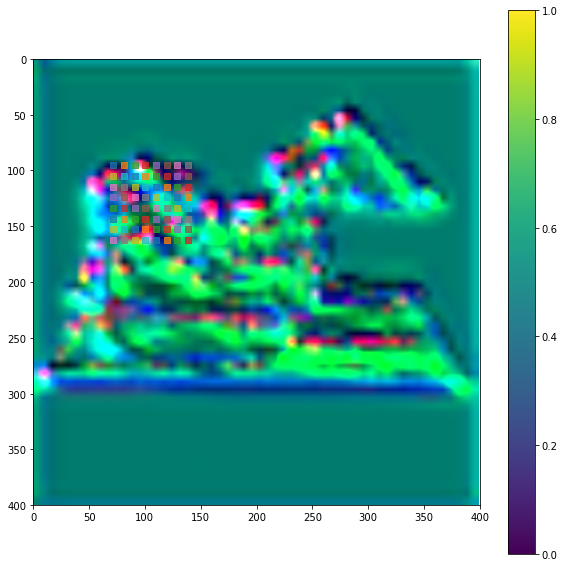

In [598]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb_features_resize.detach()[0, :3].permute(1,2,0))
plt.plot(uv[40:70:4, 30:60:4, -1, 0].reshape(-1, 1).T,
         uv[40:70:4, 30:60:4, -1, 1].reshape(-1, 1).T, alpha=0.75, linewidth=4, marker='s')
plt.ylim([H, 0])
plt.xlim([0, W])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


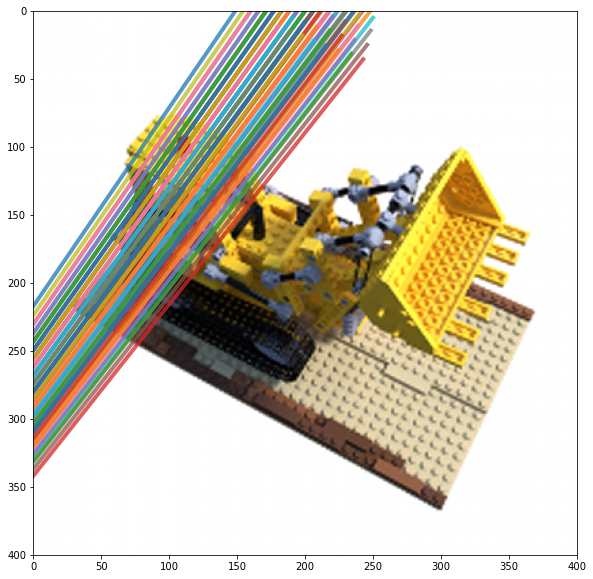

In [601]:
plt.figure(figsize=(10, 10))
plt.imshow(target_resize[0].permute(1,2,0))
plt.plot(uv[40:70:4, 30:60:4, :, 0].reshape(-1, samples_per_ray).T,
         uv[40:70:4, 30:60:4, :, 1].reshape(-1, samples_per_ray).T, alpha=0.75, linewidth=4)
plt.ylim([H, 0])
plt.xlim([0, W])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


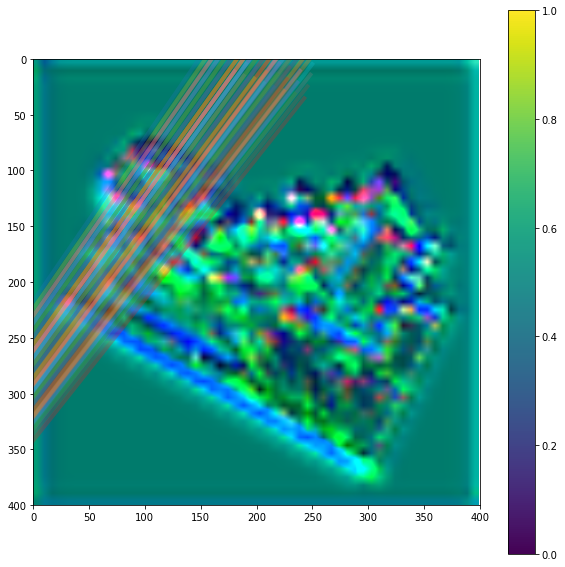

In [602]:
plt.figure(figsize=(10, 10))
plt.imshow(target_features_resize[0, :3].permute(1,2,0))
plt.plot(uv[40:70:4, 30:60:4, :, 0].reshape(-1, samples_per_ray).T,
         uv[40:70:4, 30:60:4, :, 1].reshape(-1, samples_per_ray).T, alpha=0.3, linewidth=4)
plt.ylim([H, 0])
plt.xlim([0, W])
plt.colorbar()
plt.show()

In [649]:
# plt.imshow(data['extras']['raw'][..., 3].sum(dim=-1).detach())
# plt.colorbar()
data['extras']['weights'].shape

torch.Size([168, 168, 192])

In [677]:
norm_uv = uv / torch.tensor([H,W]) * 2 - 1

target_feature_samples = F.grid_sample(
#     target_resize.expand(samples_per_ray, -1, -1, -1),
    target_features_resize.expand(samples_per_ray, -1, -1, -1),
    norm_uv.permute(2, 0, 1, 3),  # [samples_per_ray, consistency_nH, consistency_nW, 2]
    align_corners=True,
    padding_mode='border',
    mode=features_sample_interpolation,
)

# TODO: opacity-weighted average of features along ray rather than simple average
# target_feature_samples = target_feature_samples.mean(dim=0)
weights = data['extras']['weights'].permute(2, 0, 1).unsqueeze(1)
print(weights.shape, target_feature_samples.shape)
target_feature_samples = weights * target_feature_samples
target_feature_samples = target_feature_samples.sum(dim=0, keepdim=True)
target_feature_samples.shape

torch.Size([192, 1, 168, 168]) torch.Size([192, 256, 168, 168])


torch.Size([1, 256, 168, 168])

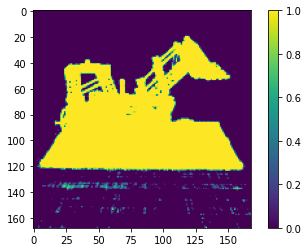

In [699]:
plt.imshow(data['extras']['acc_map'].detach())
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


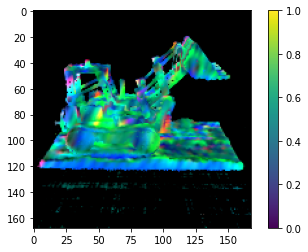

In [690]:
# plt.imshow(target_feature_samples.detach().squeeze(0).mean(dim=0), vmin=0, vmax=1)
plt.imshow(target_feature_samples.detach().squeeze(0)[:3].permute(1,2,0), vmin=0, vmax=1)
plt.colorbar()

TypeError: Invalid shape (3, 168, 168) for image data

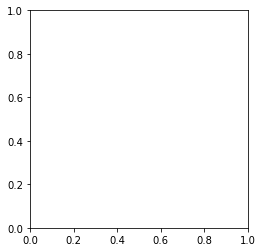

In [715]:
plt.imshow(rgb_features_resize_c[0].mean(dim=0), vmin=0, vmax=1)
plt.colorbar()

In [714]:
masked_loss = True
consistency_loss_comparison = ['mse', 'cosine_sim']

aligned_feature_loss = []
if 'mse' in consistency_loss_comparison:
    mse = F.mse_loss(rgb_features_resize_c, target_feature_samples, reduction='none')
    if masked_loss:
        mse = mse * data['extras']['acc_map'].unsqueeze(0).unsqueeze(1)
    aligned_feature_loss.append(mse.mean())

if 'cosine_sim' in consistency_loss_comparison:
    sim = F.cosine_similarity(rgb_features_resize_c, target_feature_samples, dim=1)
    if masked_loss:
        sim = sim * data['extras']['acc_map'].unsqueeze(0)
    aligned_feature_loss.append(-sim.mean())

aligned_feature_loss

[tensor(0.0226, grad_fn=<MeanBackward0>),
 tensor(-0.3210, grad_fn=<NegBackward>)]

In [685]:
F.cosine_similarity(rgb_features_resize_c, target_feature_samples, dim=1).mean()

tensor(0.3648, grad_fn=<MeanBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


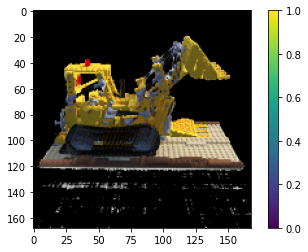

In [670]:
plt.imshow(target_feature_samples.detach().permute(1,2,0))
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


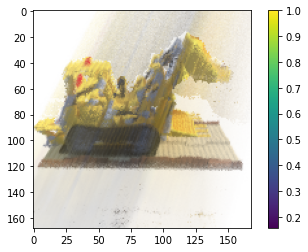

In [606]:
plt.imshow(target_feature_samples.permute(1,2,0))
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


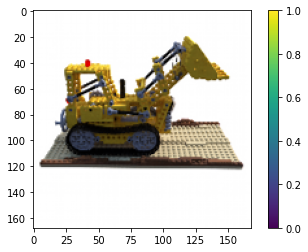

In [532]:
plt.imshow(target_feature_samples.permute(1,2,0))
plt.colorbar()

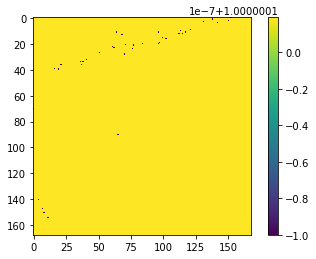

In [459]:
plt.imshow(target_feature_samples.mean(dim=0, keepdims=True).permute(1,2,0))
plt.colorbar()

In [423]:
target_feature_samples.shape

torch.Size([192, 256, 168, 168])

In [273]:
data['target'].detach().squeeze(0).permute(1, 2, 0)

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


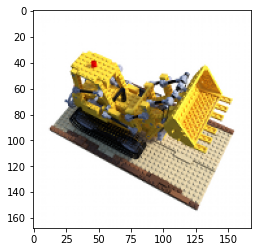

In [295]:
plt.imshow(target_resize.squeeze(0).permute(1, 2, 0))

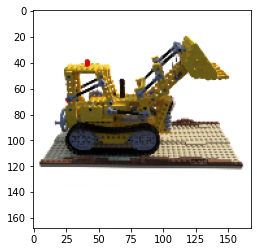

In [275]:
plt.imshow(data['rgb'].detach().squeeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


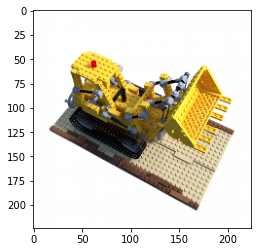

In [274]:
plt.imshow(data['target'].detach().squeeze(0).permute(1, 2, 0))

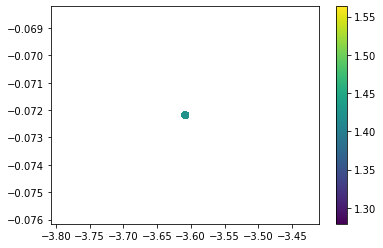

In [276]:
plt.scatter(data['rays'][0][..., 0], data['rays'][0][..., 1], c=data['rays'][0][..., 2])
plt.colorbar()
# plt.xlim([-.157, -.154])

In [125]:
color.shape

torch.Size([128, 4])

In [112]:
rendered_pts_camera[:2, :2, :, 0].reshape(-1, 128).shape

torch.Size([4, 128])